In [6]:
import numpy as np
import os
from utils2 import * 
import skimage.io as io
import sys
sys.stdout = open('prints.txt', 'w')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from IPython import display
args = {
        "path": "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2/",
        "idx": 89,
        "energy_kev": 18.0,
        "detector_pixel_size": 2.57 * 1e-6,
        "distance_sample_detector": 0.15,
        "alpha": 1e-8,
        "delta_beta": 1,
        "pad": 1,
        "method": 'TIE',
        'iter_num': 200,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 1.0,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': False,
        'recon_monitor': True,
        'seed': 42,
        'filter': True,
        'generator': None,
        'discriminator': None,
        'filter_optimizer': None,
        'generator_optimizer': None,
        'discriminator_optimizer': None,
    }


In [7]:

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, MaxPooling2D, UpSampling2D, concatenate, Dense, Conv2D, Conv2DTranspose, \
    Flatten, concatenate, \
        BatchNormalization, Dropout, \
            ReLU,LeakyReLU, Add, Activation
from tensorflow.keras.models import Model, Sequential, load_model

def dense_norm(units, dropout, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Dense(units, 
            #   activation=tf.nn.tanh, 
              use_bias=True, 
              kernel_initializer=initializer))
    result.add(Dropout(dropout))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def conv2d_norm(filters, size, strides, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2D(filters, 
               size, 
               strides=strides, 
               padding='same',
               kernel_initializer=initializer, 
               use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def dconv2d_norm(filters, size, strides, apply_dropout=False):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2DTranspose(filters, 
                        size, 
                        strides=strides,
                        padding='same',
                        kernel_initializer=initializer,
                        use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.25))

    result.add(LeakyReLU())

    return result



def make_generator(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))
    x = Flatten()(inputs)
    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),

    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    last = conv2d_norm(output_num, 3, 1)

    for fc in fc_stack:
        x = fc(x)

    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])
    # Convolutions
    for conv in conv_stack:
        x = conv(x)

    for dconv in dconv_stack:
        x = dconv(x)
    x = last(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model


def make_generator_rev(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))

    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),

    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    
    last_1 = conv2d_norm(1, 3, 1)
    last = conv2d_norm(output_num, 3, 1)
    
    #model structure
    x = conv2d_norm(conv_num, conv_size+2, 1)(inputs)
    for conv in conv_stack:
        x = conv(x)

    for dconv in dconv_stack:
        x = dconv(x)
    x = dconv2d_norm(conv_num, conv_size+2, 1)(x)
    
    x = last_1(x)
    x = Flatten()(x)

    for fc in fc_stack:
        x = fc(x)
    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])

    x = last(x)    
    model = Model(inputs=inputs, outputs=x) 
    return model


def make_filter(img_h, img_w):
    inputs = Input(shape=[img_h, img_w, 1])
    down_stack = [
        conv2d_norm(16, 3, 1),  # (batch_size, 128, 128, 64)
        conv2d_norm(16, 3, 1)
    ]

    up_stack = [

        dconv2d_norm(16, 3, 1),  # (batch_size, 128, 128, 128)
        dconv2d_norm(16, 3, 1)
    ]
    last = conv2d_norm(1, 3, 1)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)


def make_discriminator(nang, px):
    model = Sequential()
    model.add(Conv2D(16, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[nang, px, 1]))
    model.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1))

    return model

def unet(img_h, img_w, output_num = 2, depth=4, conv_num=64, conv_size=3):
    inputs = Input(shape=(img_h, img_w, 1))
    conv_stack = [
        conv2d_norm(conv_num, conv_size, 1),
        conv2d_norm(conv_num*2, conv_size, 1),
        conv2d_norm(conv_num*3, conv_size, 1),
        conv2d_norm(conv_num*4, conv_size, 1),
    ]

    dconv_stack = [
        dconv2d_norm(conv_num*3, conv_size, 1),
        dconv2d_norm(conv_num*2, conv_size, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    up = UpSampling2D(size=(2, 2))
     
    down = MaxPooling2D(pool_size=(2, 2))
    last = conv2d_norm(output_num, conv_size, 1)

    #model structure
    x = inputs
    for conv in conv_stack:
        x = conv(x)
        x = down(x)

    for dconv in dconv_stack:
        x = up(x)
        x = dconv(x)

    x = last(x)

    #to original size
    x = UpSampling2D(size=(2, 2))(x)
    model = Model(inputs=inputs, outputs=x)
    print(model.summary())
    return model


In [8]:

def plot_or_show_images(images, rows = 1, cols = 5, show_or_plot = 'plot', random = True, cmap = 'None', figsize = (20, 20), title = ''):
    #if images is a pandas dataframe, convert to numpy array
        
    if len(images) == 0:
        print("no images to plot")
        return None
    elif len(images) == 1:
        rows = 1
        cols = 1
    elif len(images) < rows*cols:
        rows = 1
        cols = len(images)
    else:
        pass
    #generate random numbers rows*cols times and take the images with the random numbers
    random_numbers = np.random.randint(0, len(images), rows*cols)
    if random:
        images = [images[i] for i in random_numbers]
    else:
        images = images[:rows*cols]

    #if images are complex, take the absolute value
    if np.iscomplexobj(images[0]):
        #exponent the images
        
        # images = [np.exp(np.imag(image) - np.real(image)) for image in images]
        images = [np.abs(image) for image in images]
        # print("images are complex, taking the np.exp(imag - real) value")

    #if the images is 4D, 
    if len(images[0].shape) == 4:
        shape = images[0].shape
        if shape[0] > shape[1] and shape[0] > shape[2]:
            images = [image[0, :, :, 0] for image in images]
        elif shape[2] > shape[0] and shape[2] > shape[1]:
            images = [image[:, :, 0, 0] for image in images]
        else:
            images = [images[0,:,:,0] for image in images]
        images = [image[0,:, :, 0] for image in images]

    shape = images[0].shape
    if rows == 1 and cols == 1:
        figsize = (10,10)
        fig = plt.figure(figsize=figsize)
        plt.imshow(images[0]) if show_or_plot == 'show' else plt.plot(images[0][shape[0]//2, :])
        plt.axis('on')
        if random:
            plt.title('min: ' + str(np.min(images))[:6] + ' max: ' + str(np.max(images))[:6] + 'im_' + str(random_numbers[0]), fontsize = 12)
        else:
            plt.title('min: ' + str(np.min(images))[:6] + ' max: ' + str(np.max(images))[:6], fontsize = 12)
        if title != '':
            plt.title(title)
        #if cmap is 
        fig.colorbar(plt.imshow(images[0])) if show_or_plot == 'show' else None
        plt.gray()
        plt.show()
        return None
    
    figsize = (shape[1]*cols/100, shape[0]*rows/100)
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        counter = 0
        for j in range(cols):
            if show_or_plot == 'show':
                if np.iscomplexobj(images[j]):
                    ax[j].imshow(np.exp(np.imag(images[j]) - np.real(images[j])))
                else:
                    ax[j].imshow(images[j])
                ax[j].axis('on')
                if random:
                    if title == '':
                        title = 'min: ' + str(np.min(images[j]))[:6] + ' max: ' + str(np.max(images[j]))[:6] + 'im_' + str(random_numbers[counter])

                    if type(title) == list:
                        title = title[counter]
                    if type(title) == str and title != '':
                        title = title + '_im_' + str(random_numbers[counter])
                else:
                    title = 'min: ' + str(np.min(images[j]))[:6] + ' max: ' + str(np.max(images[j]))[:3]
                ax[j].set_title(title, fontsize = 12)
                ax[j].axis('off')
                fig.colorbar(ax[j].imshow(images[j]), ax=ax[j])
                
            elif show_or_plot == 'plot':    
                if np.iscomplexobj(images[j]):
                    ax[j].plot((np.exp(np.imag(images[j]) - np.real(images[j])))[shape[0]//2, :])
                else:
                    ax[j].plot(images[j][shape[0]//2, :])
                ax[j].axis('on')
                if random:
                    if title == '':
                        title = 'min: ' + str(np.min(images[j]))[:6] + ' max: ' + str(np.max(images[j]))[:6] + 'im_' + str(random_numbers[counter])

                    if type(title) == list:
                        title = title[counter]
                    if type(title) == str and title != '':
                        title = title + '_im_' + str(random_numbers[counter])
                else:
                    title = 'min: ' + str(np.min(images[j]))[:6] + ' max: ' + str(np.max(images[j]))[:6]
                ax[j].set_title(title, fontsize = 12)   
                   
            counter += 1
    else:
        counter = 0
        for i in range(rows):
            for j in range(cols):
                if show_or_plot == 'show':
                    ax[i, j].imshow(images[counter])
                    ax[i, j].axis('on')
                    if random:
                        title = 'min: ' + str(np.min(images[counter]))[:6] + ' max: ' + str(np.max(images[counter]))[:6] + 'im_' + str(random_numbers[counter])
                    else:
                        title = 'min: ' + str(np.min(images[counter]))[:6] + ' max: ' + str(np.max(images[counter]))[:6]
                    ax[i, j].set_title(title, fontsize = 12)
                    

                elif show_or_plot == 'plot':    
                    ax[i, j].plot(images[counter][shape[0]//2, :])
                    ax[i, j].axis('on')
                    if random:
                        title = 'min: ' + str(np.min(images[counter]))[:6] + ' max: ' + str(np.max(images[counter]))[:6] + 'im_' + str(random_numbers[counter])
                    else:
                        title = 'min: ' + str(np.min(images[counter]))[:6] + ' max: ' + str(np.max(images[counter]))[:6]

                    ax[i, j].set_title(title, fontsize = 12)

                elif show_or_plot == 'both':
                    ax[i, j].imshow(images[counter])
                    ax[i, j].axis('on')
                    if random:
                        title = 'min: ' + str(np.min(images[counter]))[:6] + ' max: ' + str(np.max(images[counter]))[:6] + 'im_' + str(random_numbers[counter])
                    else:
                        title = 'min: ' + str(np.min(images[counter]))[:6] + ' max: ' + str(np.max(images[counter]))[:6]
                    ax[i, j].set_title(title, fontsize = 12)
                    
                    ax2 = ax[i, j].twinx()
                    ax2.plot(images[counter][shape[0]//2, :])
                    ax2.axis('on')
                    ax2.set_title(title, fontsize = 12)
                    fig.colorbar(ax[i, j].imshow(images[counter]), ax=ax[i, j])
                counter += 1
    plt.gray()
    plt.show()
    return None

def visualize(pure = [] , show_or_plot = 'show', rows = 1, cols = 5, random = False, in_parallel = False):
    if show_or_plot == 'show':
        plot_or_show_images(pure, show_or_plot='show', rows = rows, cols = cols, random = random)
    elif show_or_plot == 'plot':
        plot_or_show_images(pure, show_or_plot='plot', rows = rows, cols = cols, random = random)

def visualize_interact(pure = []):
    import ipywidgets as widgets
    from ipywidgets import interact
    from IPython.display import display
    interact(visualize, pure = widgets.fixed(pure), show_or_plot = widgets.Dropdown(options=['show', 'plot'], value='show', description='Show or plot:'), rows = widgets.IntSlider(min=1, max=10, step=1, value=1, description='Rows:'), cols = widgets.IntSlider(min=1, max=10, step=1, value=3, description='Columns:'))
     
 

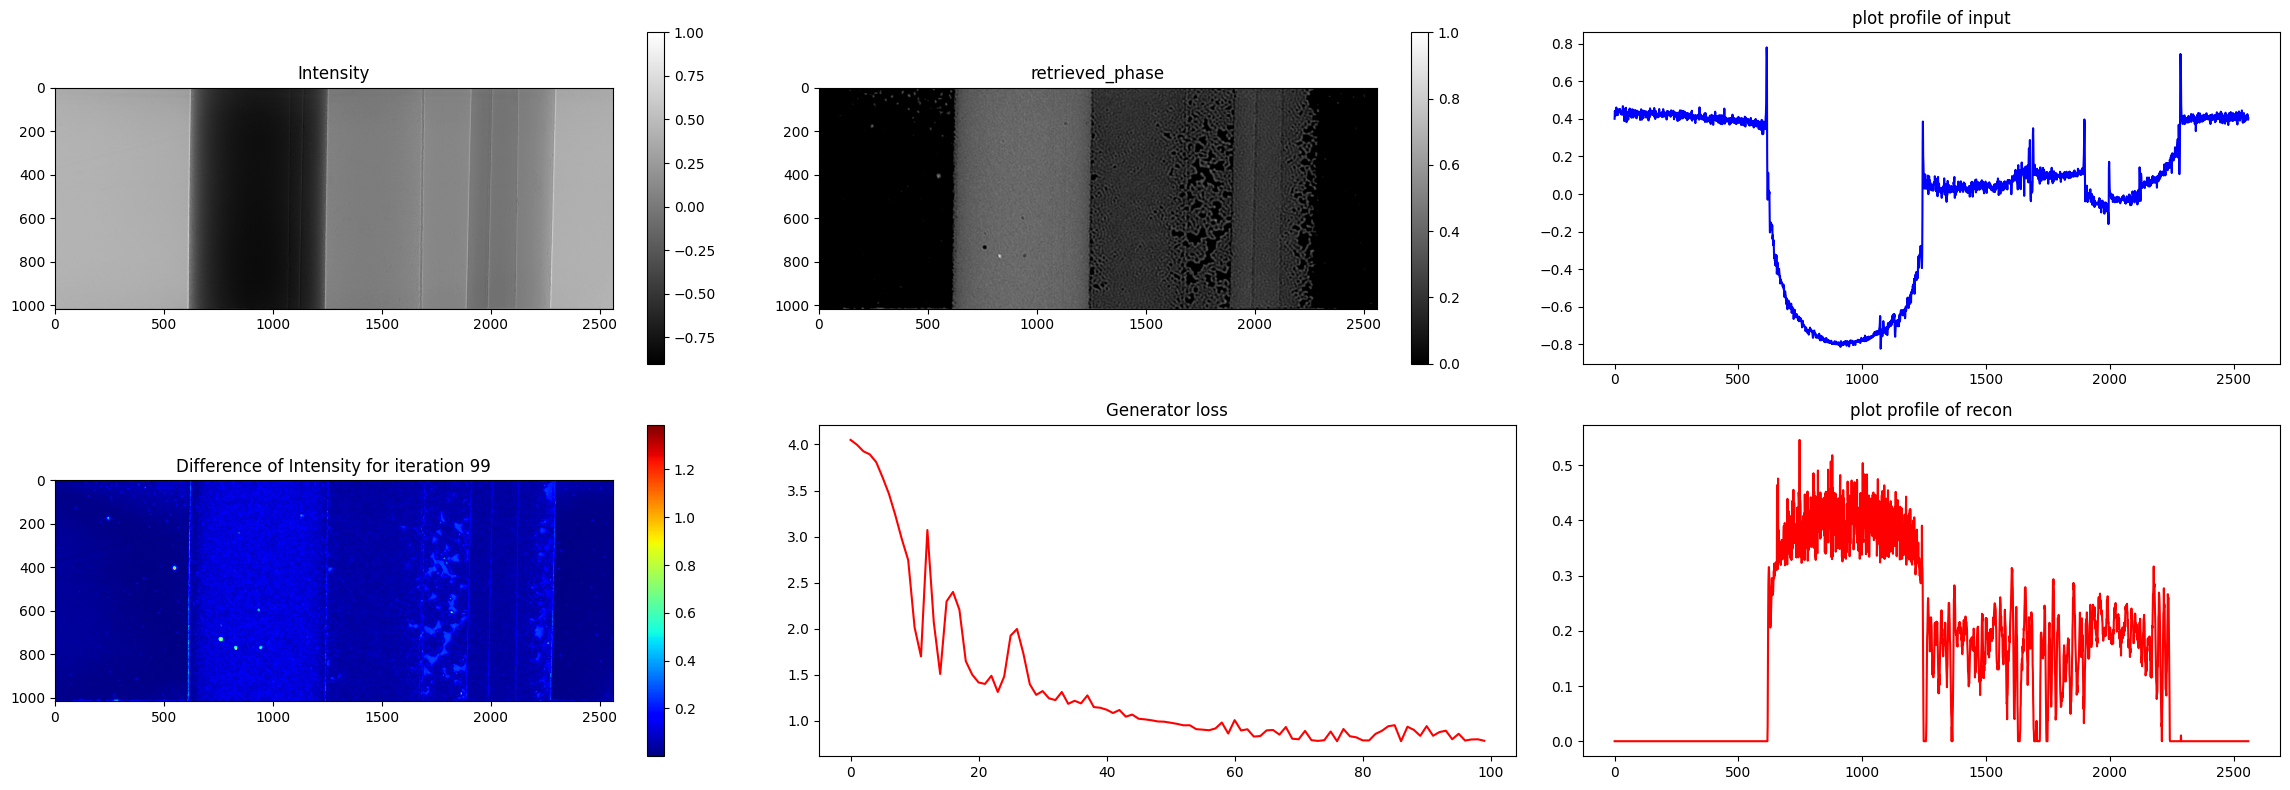

In [17]:
from models import make_generator, make_discriminator, make_filter
from utils import RECONmonitor, ffactor, fresnel_operator
from skimage.exposure import equalize_hist, equalize_adapthist, rescale_intensity, match_histograms

import skimage.io as io

import tensorflow as tf
import os
import numpy as np
import time

from IPython import display
class RECONmonitor:
    def __init__(self, recon_target):
        self.fig, self.axs = plt.subplots(2, 3, figsize=(23, 8))
        self.recon_target = recon_target
        if self.recon_target == 'tomo':
            self.plot_txt = 'Sinogram'
        elif self.recon_target == 'phase':
            self.plot_txt = 'Intensity'

    def initial_plot(self, img_input):
        px, py = img_input.shape
        self.im0 = self.axs[0, 0].imshow(img_input, cmap='gray')
        self.axs[0, 0].set_title(self.plot_txt)
        self.fig.colorbar(self.im0, ax=self.axs[0, 0])
        self.axs[0, 0].set_aspect('equal','box')
        self.im1 = self.axs[1, 0].imshow(img_input, cmap='jet')
        self.tx1 = self.axs[1, 0].set_title('Difference of ' + self.plot_txt + ' for iteration 0')
        self.fig.colorbar(self.im1, ax=self.axs[1, 0])
        self.axs[0, 0].set_aspect('equal')
        self.im2 = self.axs[0, 1].imshow(np.zeros((px, py)), cmap='gray')
        self.fig.colorbar(self.im2, ax=self.axs[0, 1])
        self.axs[0, 1].set_title('retrieved_phase')
        self.im3, = self.axs[1, 1].plot([], [], 'r-')
        self.axs[1, 1].set_title('Generator loss')
        self.axs[0, 2].set_title('plot profile of input')
        self.axs[0, 2].plot(img_input[int(px/2), :], 'b-')
        self.axs[0, 2].set_title('plot profile of input')
        self.im4 = self.axs[1, 2].plot([], 'r-')
        self.axs[1, 2].set_title('plot profile of recon')
        
        
        plt.tight_layout()

    def update_plot(self, epoch, img_diff, img_rec, plot_x, plot_loss, save_path = None):
        self.tx1.set_text('Difference of ' + self.plot_txt + ' for iteration {0}'.format(epoch))
        vmax = np.max(img_diff)
        vmin = np.min(img_diff)
        self.im1.set_data(img_diff)
        self.im1.set_clim(vmin, vmax)
        self.im2.set_data(img_rec)
        vmax = np.max(img_rec)
        vmin = np.min(img_rec)
        self.im2.set_clim(vmin, vmax)
        self.axs[1, 1].plot(plot_x, plot_loss, 'r-')
        self.axs[1, 2].plot(img_rec[int(img_rec.shape[0]/2), :], 'r-')
        plt.pause(0.1)

    def close_plot(self):
        plt.close()
# @tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                                       labels=tf.ones_like(real_output)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                       labels=tf.zeros_like(fake_output)))
    total_loss = real_loss + fake_loss
    return total_loss


def l1_loss(img1, img2):
    return tf.reduce_mean(tf.abs(img1 - img2))
def l2_loss(img1, img2):
    return tf.square(tf.reduce_mean(tf.abs(img1-img2)))



# @tf.function
def generator_loss(fake_output, img_output, pred, l1_ratio):
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                      labels=tf.ones_like(fake_output))) \
               + l1_loss(img_output, pred) * l1_ratio
    return gen_loss


# @tf.function
def filer_loss(fake_output, img_output, img_filter):
    f_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                    labels=tf.ones_like(fake_output))) + \
              l1_loss(img_output, img_filter) *10
              # l1_loss(img_output, img_filter) * 10
    return f_loss



def tfnor_phase(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    return img

import tensorflow as tf
def tf_reshape(img):
    """
    output: [1, img.shape[0], img.shape[1], 1]
    """
    try:
        img = tf.convert_to_tensor(img)
        return tf.cast(tf.reshape(img, [1, img.shape[0], img.shape[1], 1]), dtype=tf.float32)
    except:
        if type(img) is np.ndarray or type(img) is tf.Tensor:
            if len(img.shape) == 2:
                img = tf.reshape(img, [1, img.shape[0], img.shape[1], 1])
        elif type(img) is list:
            if len(img[0].shape) == 2:
                img = tf.stack([tf_reshape(i) for i in img])
                img = tf.reshape(img, [img.shape[0], img.shape[1], img.shape[2], 1])
        else:
            try:
                img = img.numpy()
                img = tf_reshape(img)
            except:
                raise TypeError("img must be a list, np.ndarray or tf.Tensor")
        img = tf.cast(img, dtype=tf.float32)
        return img


def tfnor_phase(img):
    img = tf.image.per_image_standardization(tf_reshape(img))
    img = img / tf.reduce_max(img)
    img = tf.reshape(img, [img.shape[0], img.shape[1], img.shape[2], 1])
    return img

def tfback_phase(img, input):
    tf.config.run_functions_eagerly(True)
    try:
        img = tf_reshape(img)[0,:,:,0].numpy()
        input = tf_reshape(input)[0,:,:,0].numpy()
        matched = match_histograms(img, input)
        # visualize([img, input, matched])
        return tf_reshape(matched)
    except:
        img_final = tf.numpy_function(match_histograms, [img, input], tf.float32)
        return tf_reshape(img_final)
    
#contrast limited adaptive histogram equalization
def tf_equalize(img):
    img = tf.image.equalize_adapthist(tf_reshape(img)[0,:,:,0])
    img = tf_reshape(img)
    return img




def FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None):
    """  Parameters: 
            E0 - initial complex field in x-y source plane
            detector_pixel_size - pixel size in microns
            lambda0 - wavelength in nm
            distance_sample_detector - distance_sample_detector-value (distance from sensor to object)
            background - optional background image to divide out from
        
        Returns: E1 - propagated complex field in x-y sensor plane"""  
    import os
    dtype = tf.complex64
    H = tf.cast(ff, dtype)
    detector_wavefield = tf.exp(tf.complex(-absorption, phase))
    detector_wavefield = tf.cast(detector_wavefield, dtype)
    # Compute FFT centered about 0
    E0fft = (tf.signal.fft2d(detector_wavefield))
    E0fft = tf.cast(E0fft, dtype)

    # Multiply spectrum with fresnel phase-factor
    print("E0fft shape: ", E0fft.shape, "H shape: ", H.shape)
    G = H * E0fft
    # Ef = tf.signal.ifft2d(tf.signal.ifftshift(G)) # Output after deshifting Fourier transform
    I = tf.abs(tf.signal.ifft2d(G))**2
    I = tf.cast(I, tf.float32)
    if dark_image is not None and ref_image is not None:
        I = I * (ref_image - dark_image) + dark_image
    I = tf_reshape(I) #without normalizing
    # I = tfnor_phase(tf.reshape(I, [1, I.shape[0], I.shape[1], 1]))
    return I

def phase_fresnel(phase, absorption, ff, shape_x, shape_y):
    paddings = tf.constant([[shape_x // 2, shape_y // 2], [shape_x //2, shape_y // 2]])
    pvalue = tf.reduce_mean(phase[:100, :])
    phase = tf.pad(phase, paddings, 'SYMMETRIC')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    abfs = tf.complex(-absorption, phase)
    abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    ifp = tfnor_phase(ifp)
    return ifp


def ssim_check(image, rec, ff, distance_sample_detector):
    shape_x, shape_y = image.shape
    propagated = FresnelPropagator(rec[1], rec[0], ff, distance_sample_detector)
    data_im = tfnor_phase(tf.reshape(image, [1, shape_x, shape_y, 1]))
    ssim = tf.image.ssim(data_im, propagated, max_val = 1.0)
    print("SSIM between the input image and the reconstructed image is {}".format(ssim))
    return ssim

def peak_signal_to_noise(image, rec_phantom, ff, distance_sample_detector):
    shape_x, shape_y = image.shape
    propagated = FresnelPropagator(rec_phantom[1], rec_phantom[0], ff, distance_sample_detector)
    data_im = tfnor_phase(tf.reshape(image, [1, shape_x, shape_y, 1]))
    # visualize_interact([propagated[0,:,:,0], data_im[0,:,:,0]])
    psnr = tf.image.psnr(data_im, propagated, max_val = 1.0)
    print("Noise to signal ratio is {}".format(psnr))
    return psnr


class GANphase():
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        #transform type can be reshape or normalize
        if 'transform_type' not in kwargs:
            self.transform_type = 'normalize'

        if self.transform_type  == 'reshape':
            self.transform_func = tf_reshape 
            tf.config.run_functions_eagerly(True)  #important to set this to True due to the match function
            tf.config.experimental_run_functions_eagerly(True)
        elif self.transform_type  == 'normalize':
            self.transform_func = tfnor_phase
            tf.config.run_functions_eagerly(False)  #important to set this to false
        elif self.transform_type  == 'standardize':
            self.transform_func = tf.image.per_image_standardization
        elif self.transform_type == 'contrast':
            factor = 0.7
            self.transform_func = lambda x: tf.image.adjust_contrast(x, factor)
        elif self.transform_type == 'equalize':
            self.transform_func = tf_equalize

        self.transformed_image = self.transform_func(self.image)[0,:,:,0]
        super(GANphase, self).__init__()
        
    def make_model(self):
        
        if self.filter is True:
            self.filter = make_filter(self.transformed_image.shape[0],
                                  self.transformed_image.shape[1])
        self.generator = make_generator(self.transformed_image.shape[0],
                                        self.transformed_image.shape[1],
                                        self.conv_num,
                                        self.conv_size,
                                        self.dropout,
                                        2)
        # self.generator = unet(self.transformed_image.shape[0],self.transformed_image.shape[1], 2, 6)
        self.discriminator = make_discriminator(self.transformed_image.shape[0],
                                                self.transformed_image.shape[1])
        self.filter_optimizer = tf.keras.optimizers.Adam(5e-3)
        self.generator_optimizer = tf.keras.optimizers.Adam(self.g_learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(self.d_learning_rate)

    def make_chechpoints(self):
        checkpoint_dir = '/data/ganrec/training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    @tf.function
    def rec_step(self, transformed_image, ff):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            recon = self.generator(transformed_image)
            # recon = tfa.image.median_filter2d(recon)
            phase = recon[:, :, :, 0]
            absorption = recon[:, :, :, 1] * self.abs_ratio
            #physical constraint
            phase = tfnor_phase(phase)
            phase = tf.nn.relu(phase)
            phase = tf.reshape(phase, [self.shape_x, self.shape_y])
            absorption = tfnor_phase(absorption)
            absorption = tf.nn.relu(absorption)
            absorption = tf.reshape(absorption, [self.shape_x, self.shape_y])

            #set a constraint that the phase and absorption should be positive
            
            if self.phase_only:
                absorption = tf.zeros_like(phase)
            # i_rec = tfnor_phase(tf.reshape(FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None), [1, self.shape_x, self.shape_y, 1]))
            propagated = FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None)
            if self.transform_type == 'reshape':
                i_rec = tfback_phase(propagated, transformed_image)
            else:
                i_rec = self.transform_func(propagated)
            real_output = self.discriminator(transformed_image, training=True)
            fake_output = self.discriminator(i_rec, training=True)

            g_loss = generator_loss(fake_output, transformed_image, i_rec, self.l1_ratio)
            d_loss = discriminator_loss(real_output, fake_output)
            
            gradients_of_generator = gen_tape.gradient(g_loss,
                                                    self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(d_loss,
                                                            self.discriminator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                        self.generator.trainable_variables))            
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                        self.discriminator.trainable_variables))

        return {'phase': phase,
                'absorption': absorption,
                'i_rec': i_rec,
                'g_loss': g_loss,
                'd_loss': d_loss}


    @property
    def recon(self):
        # ff = fresnel_operator(self.shape_x, self.shape_y, self.detector_pixel_size, self.distance_sample_detector, self.energy)
        ff = self.fresnel_factor
        transformed_image = tf_reshape(self.transformed_image)
        self.make_model()

        if self.init_model:
            self.generator.load_weights(self.init_wpath+'generator.h5')
            print('generator is initilized')
            self.discriminator.load_weights(self.init_wpath+'discriminator.h5')

        phase = np.zeros((self.iter_num, self.shape_x, self.shape_y))
        absorption = np.zeros((self.iter_num, self.shape_x, self.shape_y))
        gen_loss = np.zeros(self.iter_num)

        ###########################################################################
        # Reconstruction process monitor
        if self.recon_monitor:
            
            plot_x, plot_loss = [], []
            recon_monitor = RECONmonitor('phase')
            recon_monitor.initial_plot(self.transformed_image)
            # hdisplay = display.display("", display_id=True)
        ###########################################################################
        for epoch in range(self.iter_num):

            ###########################################################################
            ## Call the rconstruction step
            step_results = self.rec_step(transformed_image, ff)
            phase[epoch, :, :] = step_results['phase']
            absorption[epoch, :, :] = step_results['absorption']
            i_rec = step_results['i_rec']
            gen_loss[epoch] = step_results['g_loss']
            d_loss = step_results['d_loss']
            # phase[epoch, :, :], absorption[epoch, :, :], i_rec, gen_loss[epoch], d_loss = self.rec_step(transformed_image,
            #                                                                                                   ff)
            ###########################################################################

            plot_x.append(epoch)
            plot_loss = gen_loss[:epoch + 1]
            if (epoch + 1) % 100 == 0:
                # checkpoint.save(file_prefix=checkpoint_prefix)
                if recon_monitor:
                    i_rec = np.reshape(i_rec, (self.shape_x, self.shape_y))
                    i_diff = np.abs(i_rec - self.transformed_image)
                    phase_plt = np.reshape(phase[epoch], (self.shape_x, self.shape_y))
                    recon_monitor.update_plot(epoch, i_diff, phase_plt, plot_x, plot_loss, None)
                    # hdisplay.update(fig)
                    if self.save_wpath != None:
                        import skimage.io as io
                        io.imsave(self.save_wpath+ 'iter_' +str(epoch)+'.tif', phase_plt, check_contrast=False)
                        io.imsave(self.save_wpath+ 'iter_' +str(epoch)+'_diff.tif', i_diff, check_contrast=False)
                print('Iteration {}: G_loss is {} and D_loss is {}'.format(epoch + 1, gen_loss[epoch], d_loss.numpy()))
        recon_monitor.close_plot()
        
        if self.save_wpath != None:
            import skimage.io as io
            self.generator.save(self.init_wpath+'generator.h5')
            self.discriminator.save(self.init_wpath+'discriminator.h5')
            io.imsave(self.save_wpath+ 'final_phase_iter_' +str(self.iter_num)+'.tif', phase[epoch][1], check_contrast=False)
            io.imsave(self.save_wpath+ 'final_absorption_iter_' +str(self.iter_num)+'.tif', absorption[epoch][0], check_contrast=False)
        return absorption[epoch], phase[epoch], i_rec, gen_loss, d_loss

class Ganrec_Dataloader():
    def __init__(self,**kwargs):
        self.kwargs = kwargs
        self.kwargs.update(get_all_info(**kwargs))
        keys = self.kwargs.keys()
        [self.__setattr__(key, self.kwargs[key]) for key in keys]
        self.dims = (self.ND, self.shape_x, self.shape_y)
        self.transformed_images = None

        super(Ganrec_Dataloader, self).__init__()

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx = None):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            kwargs.update(get_all_info(**kwargs))
            keys = kwargs.keys()
            [self.__setattr__(key, kwargs[key]) for key in keys]
            
            if type(idx) is not list:    
                self.transformed_images = tfnor_phase(self.image)
            else:
                images = [tfnor_phase(self.image[i]) for i in range(len(self.idx))]
                self.transformed_images= tf.stack(images)
        else:
            if type(self.idx) is not list:
                self.transformed_images = tfnor_phase(self.image)
            else:
                self.transformed_images = tf.stack([tfnor_phase(self.image[i]) for i in range(len(self.idx))])
        return self.transformed_images
    def normalize(self, idx = None):
        image = self.__getitem__(idx)
        image = tfnor_phase(image)
        return image
    
    def get_kwargs(self):
        return self.__dict__
    
    def visualize(self, idx = None, random = False):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            kwargs.update(get_all_info(**kwargs))
            keys = kwargs.keys()
            [self.__setattr__(key, kwargs[key]) for key in keys]
            images = self.image
        else:
            images = self.image
        if type(images) is not list:
            images = [images]

        rows = int(np.sqrt(len(images)))
        if rows ==1:
            cols = len(images)
        else:
            cols = rows + 1
        print("rows: {}, cols: {}".format(rows, cols))
        if random == False:
            visualize(images, rows = rows, cols = cols)
        else:
            visualize(images, rows = rows, cols = cols, random=True)

    def normal_visualize(self, idx = None, random = False):
        if self.transformed_images is None:
            self.__getitem__(idx)
        print(self.transformed_images.shape)
        images = [self.transformed_images[i, :, :, 0].numpy() for i in range(self.transformed_images.shape[0])]
        rows = int(np.sqrt(len(images)))
        cols = rows + 1
        if random == False:    
            visualize(images, rows = rows, cols = cols, random = False )
        else:
            visualize(images, random=True)
    
    def create_ganphase_class(self, id = None, **kwargs):
        try:
            self.transformed_images
            if self.transformed_images is None:
                self.transformed_images = self.__getitem__(id)
        except:
            raise ValueError("transformed_images is not defined")

        self.kwargs['transformed_image'] = self.transformed_images[0, :, :, 0]
        self.ganphase = GANphase(**self.kwargs)
        return self.ganphase

    def train_model(self, id = None, **kwargs):
        if kwargs is not None:
            self.kwargs.update(kwargs)
        self.ganphase = self.create_ganphase_class(id, **self.kwargs)
        print("tranformed_images shape: {}".format(self.transformed_images.shape))
        self.retrieved = self.ganphase.recon
        self.phase = self.retrieved[1]
        self.attenuation = self.retrieved[0]
        return self.retrieved
    
    def forward_propagate(self, distance = None):
        assert self.ganphase is not None, "ganphase is not defined"
        if distance is None:
            distance = self.distance_sample_detector
        self.propagated_forward = FresnelPropagator(self.phase, self.attenuation, self.fresnel_factor, distance)
        return self.propagated_forward
    def ssim_check(self):
        intenstiy = FresnelPropagator(self.phase, self.attenuation, self.fresnel_factor, self.distance_sample_detector)
        #match
        intensity = tfback_phase(intensity, self.transformed_images[0,:,:,0])
        self.ssim_value = tf.image.ssim(self.transformed_images[0,:,:,0], intensity, max_val = 1.0)
        print("SSIM value is {}".format(self.ssim_value))
        return self.ssim_value
    
args["path"] = "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2"
args["idx"] = 2
# args["idx"] = 3
args["iter_num"] = 100
args["init_model"] = False
args['transform_type'] = 'normalize'
dataloader = Ganrec_Dataloader(**args)
ganphase = dataloader.create_ganphase_class()
retrieved = dataloader.train_model()

# For the phantom data

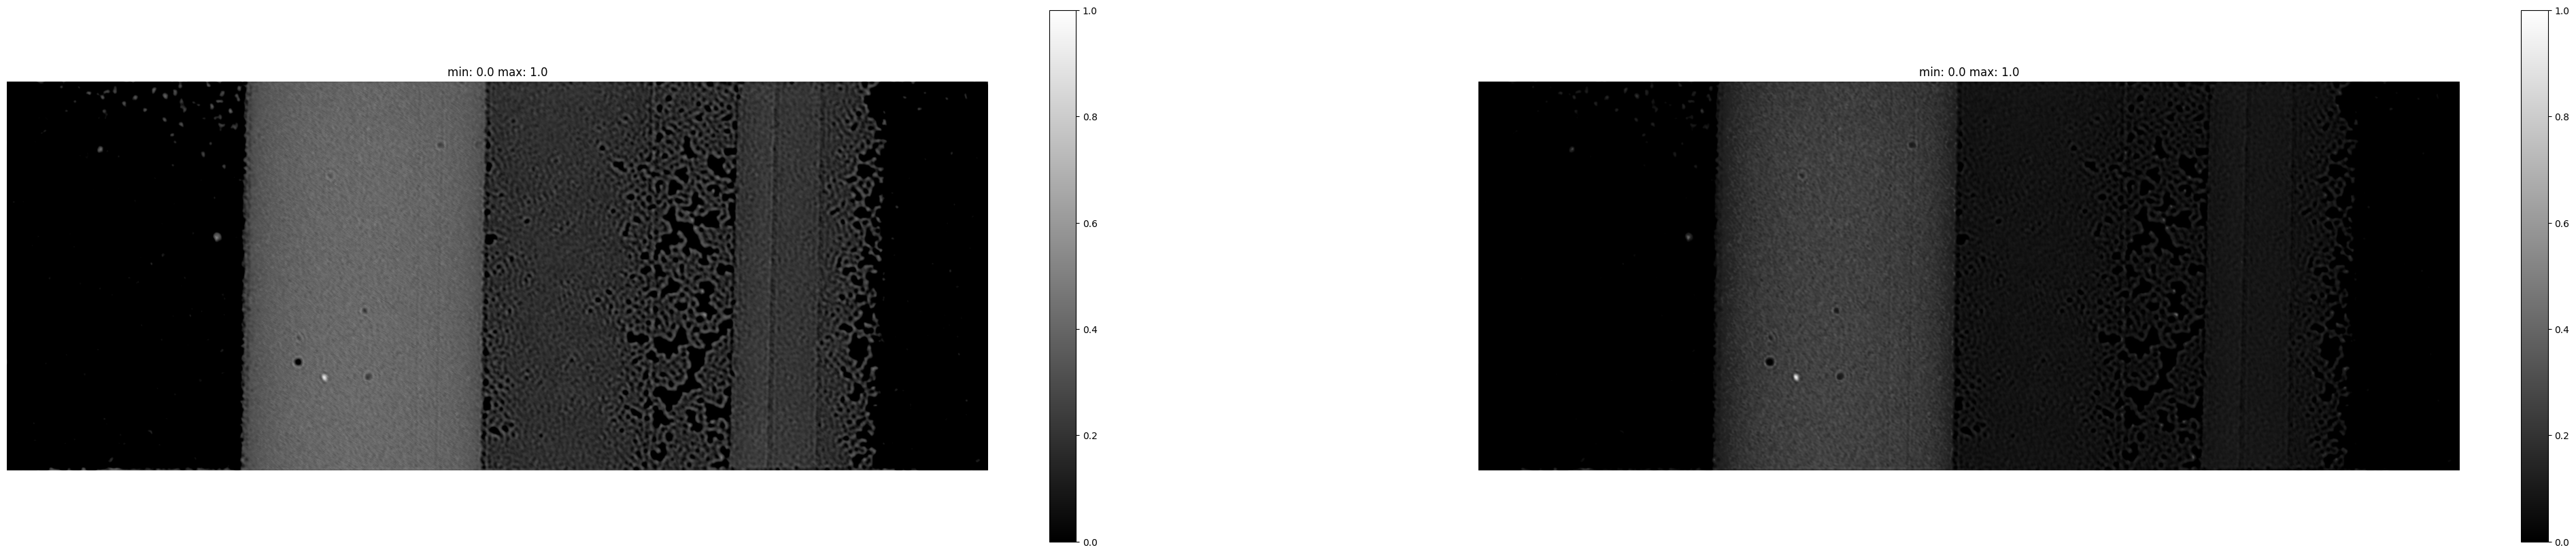

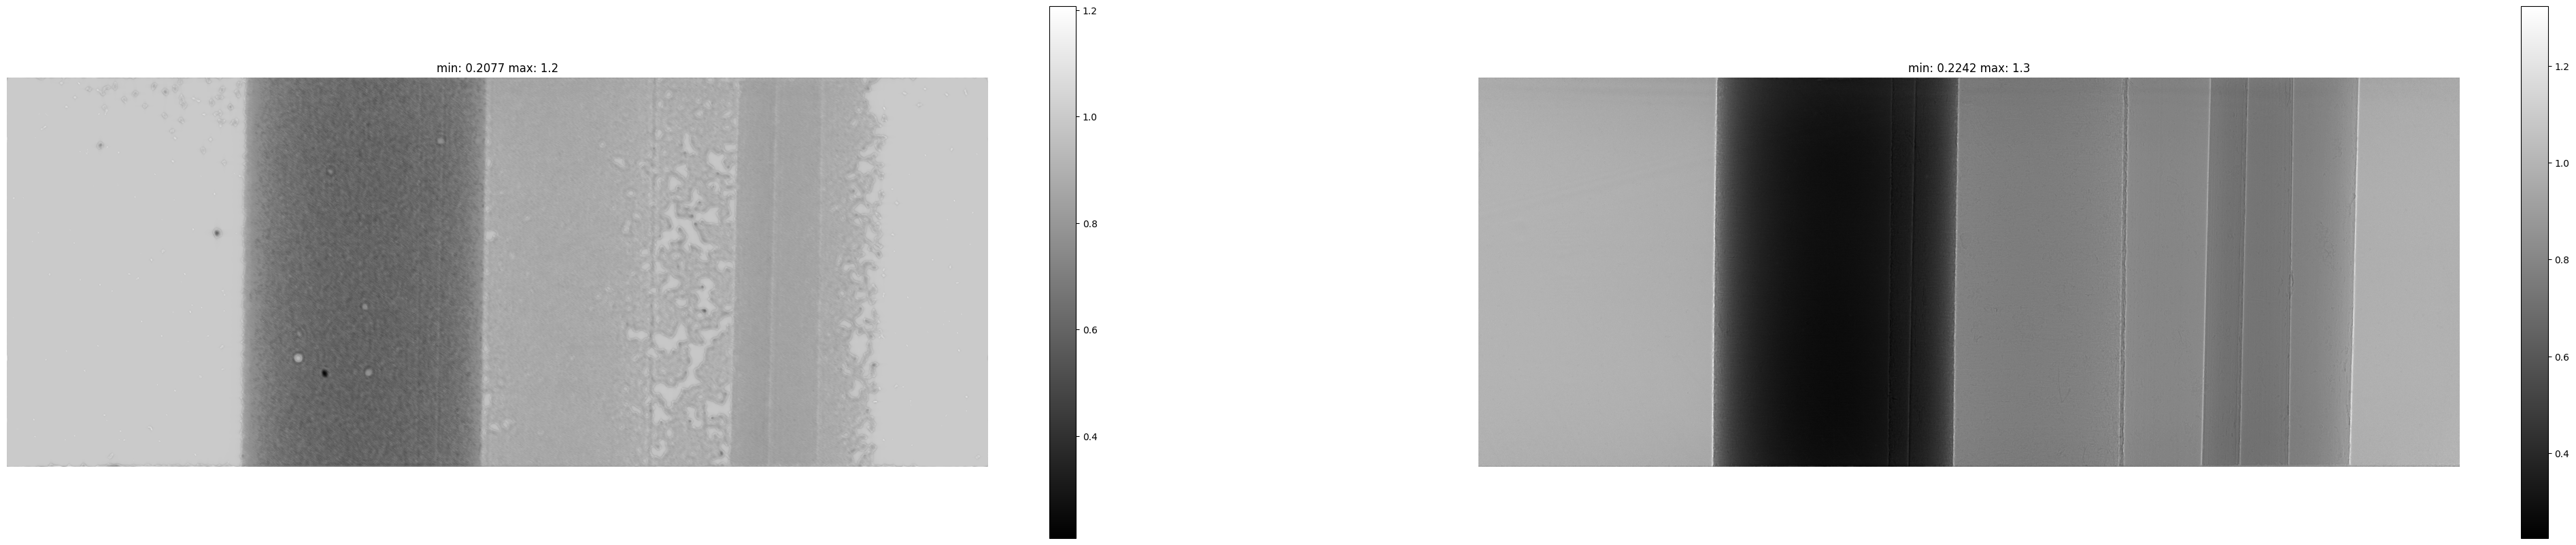

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6897301], dtype=float32)>

In [18]:
setup_info = {
    'path': "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2",
    'idx': 2,
    'energy_kev': 18.0,
    'detector_pixel_size': 2.57 * 1e-6,
    'distance_sample_detector': 0.15,
    'pad': 1,
    'alpha': 1e-8,
    'init_model': False,
    'iter_num': 300,
    'transform_type': 'normalize',
}
args.update(setup_info)
dataloader = Ganrec_Dataloader(**args)
ganphase = dataloader.create_ganphase_class()
retrieved = dataloader.train_model()

phase = retrieved[1]
attenuation = retrieved[0]
propagated = FresnelPropagator(phase, attenuation, dataloader.kwargs['fresnel_factor'], ref_image = None, dark_image = None)
print("phase shape: {}".format(phase.shape))
print("attenuation shape: {}".format(attenuation.shape))
visualize([phase, attenuation])
visualize([propagated[0, :, :, 0], dataloader.image])

matched = tfback_phase(dataloader.transformed_images[0,:,:,0], propagated[0,:,:,0])
tf.image.ssim(matched, propagated, max_val = 1.0)

# For the simulation data

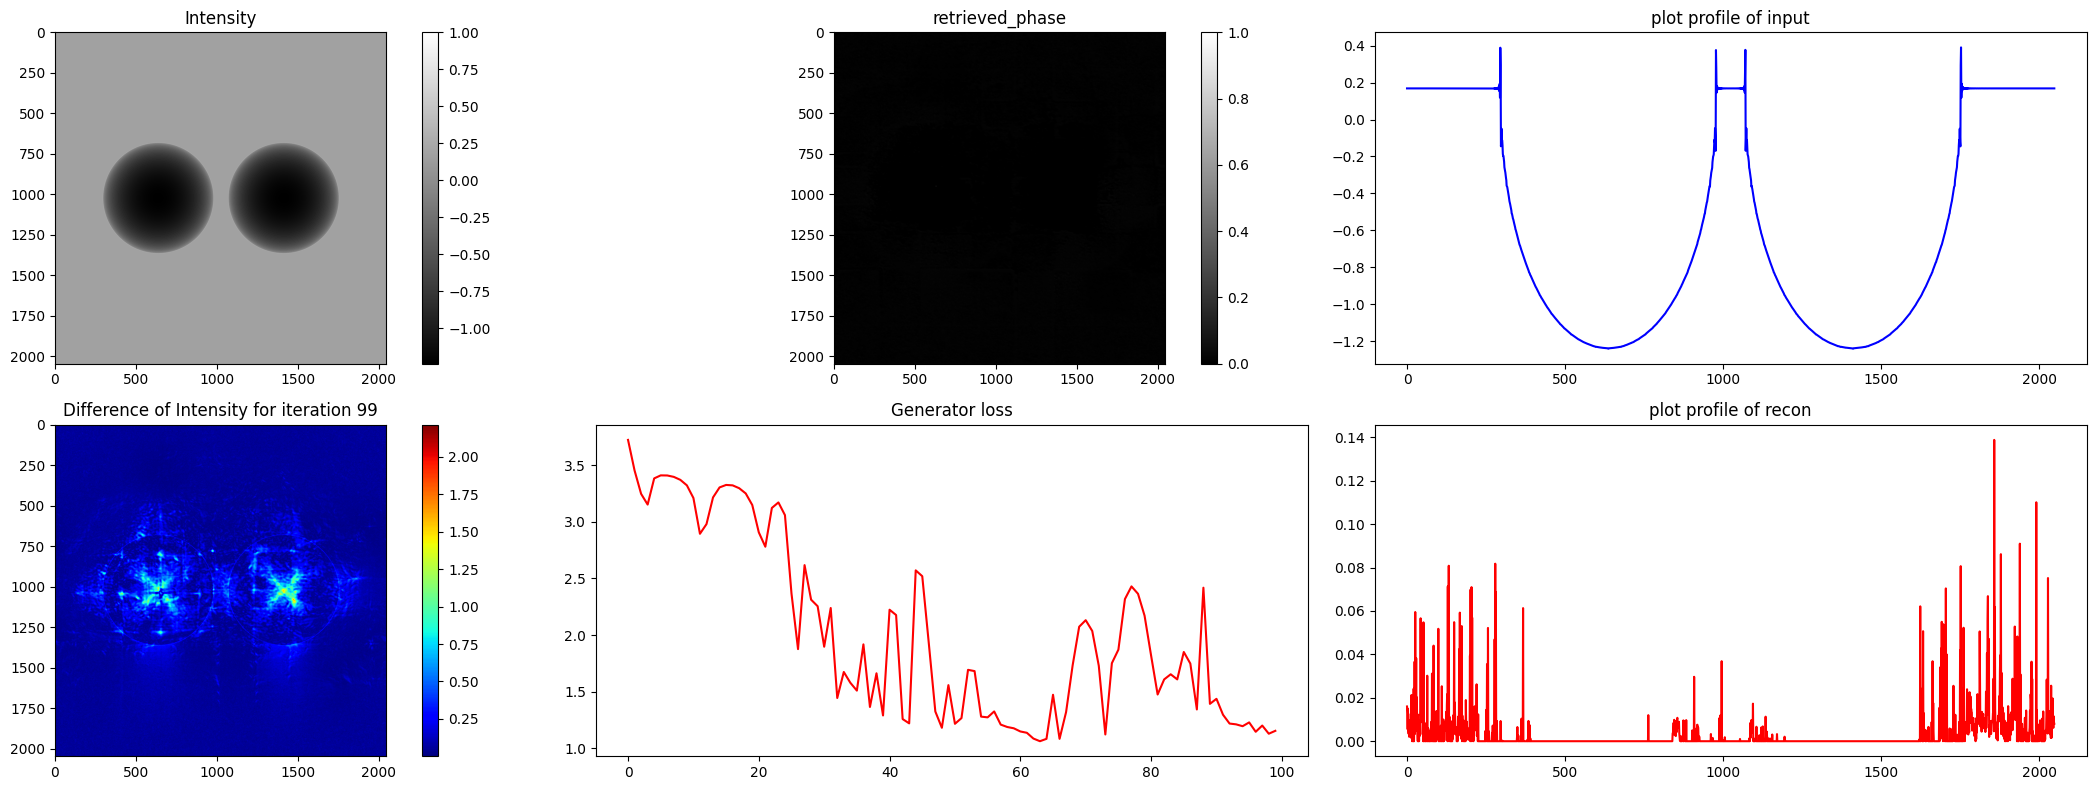

In [19]:
setup_info = {
    'path': '/home/hailudaw/hailudaw/ml_for_phase/propagations_2000/',
    'idx': 2,
    'energy_kev': 10,
    'detector_pixel_size': 5e-7,
    'distance_sample_detector': 0.5,
    'pad': 1,
    'alpha': 1e-8,
    'iter_num': 300,
    'init_model': False,
    'transform_type': 'normalize',
}
args.update(setup_info)
dataloader = Ganrec_Dataloader(**args)
ganphase = dataloader.create_ganphase_class()
retrieved = dataloader.train_model()

phase = retrieved[1]
attenuation = retrieved[0]
propagated = FresnelPropagator(phase, attenuation, dataloader.kwargs['fresnel_factor'], ref_image = None, dark_image = None)
print("phase shape: {}".format(phase.shape))
print("attenuation shape: {}".format(attenuation.shape))
visualize([phase, attenuation])
visualize([propagated[0, :, :, 0], dataloader.image])

matched = tfback_phase(dataloader.transformed_images[0,:,:,0], propagated[0,:,:,0])
tf.image.ssim(matched, propagated, max_val = 1.0)

# for the hologram data

'real_output: Tensor("sequential_118/dense_34/BiasAdd:0", shape=(1, 1), dtype=float32)'

'real_output: Tensor("sequential_118/dense_34/BiasAdd:0", shape=(1, 1), dtype=float32)'

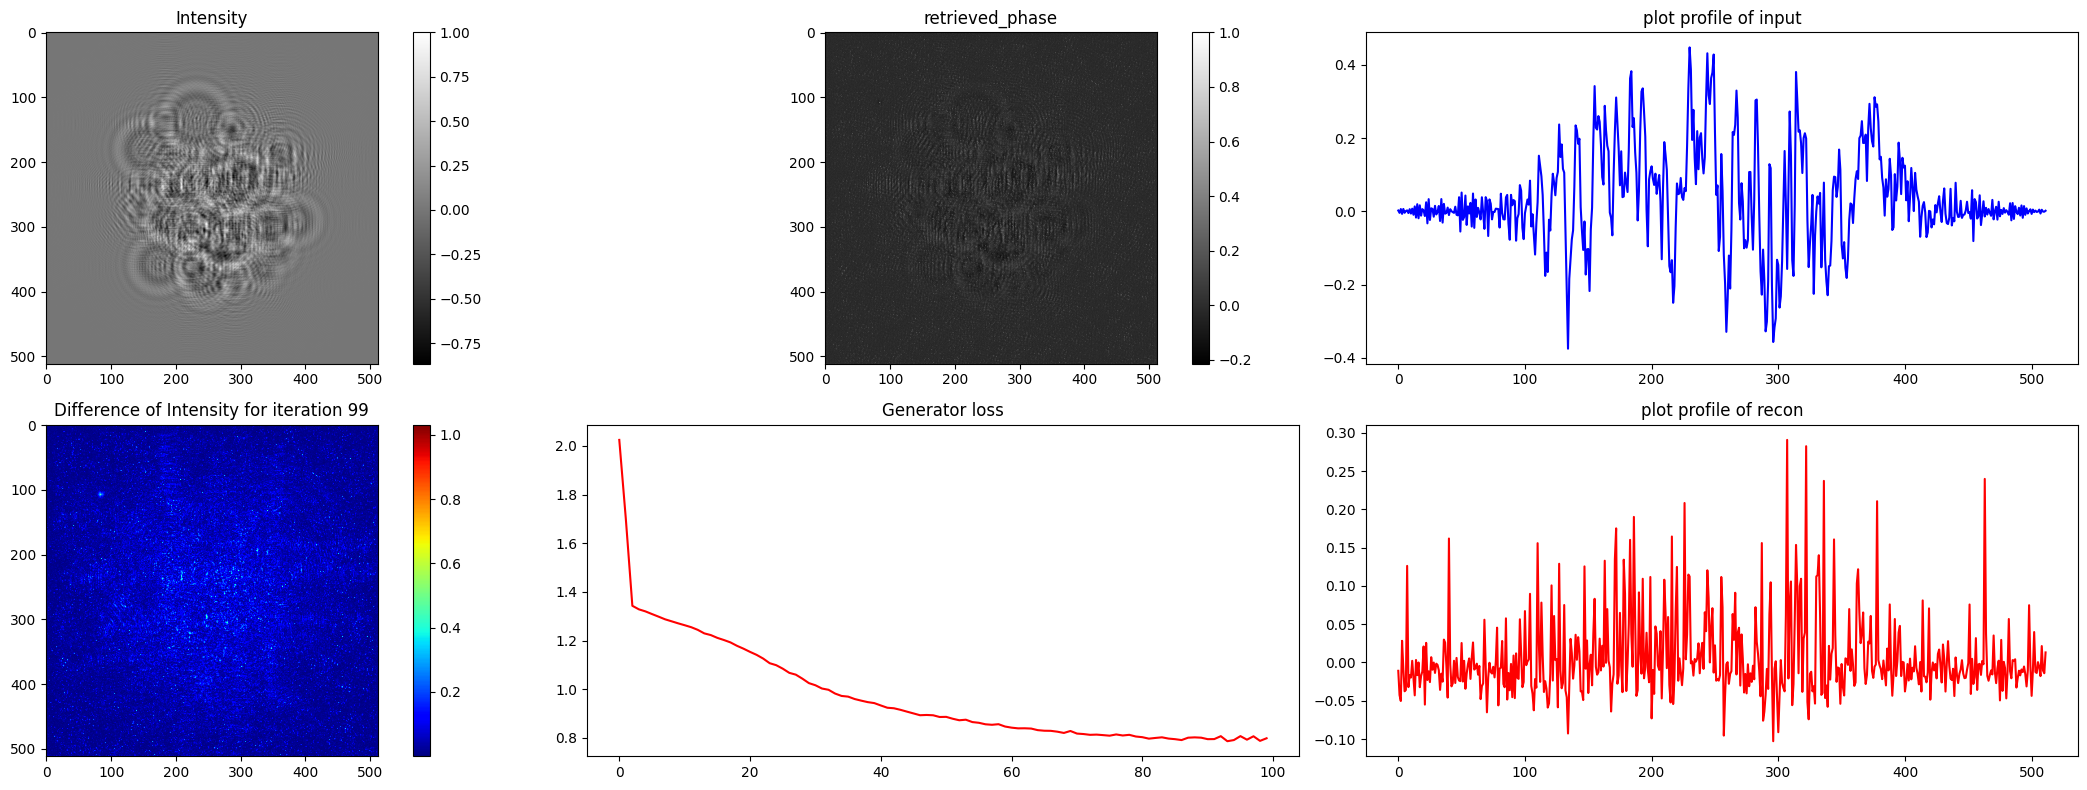

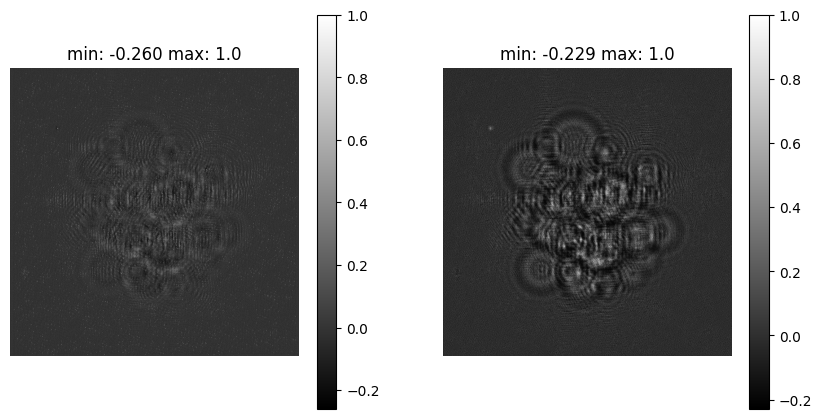

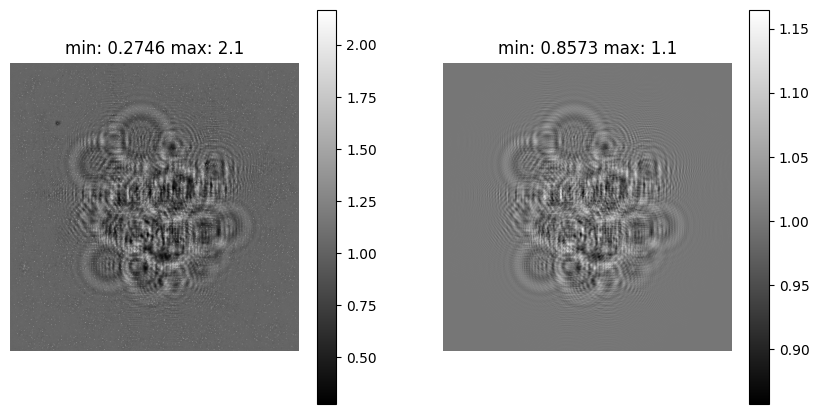

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.59731925], dtype=float32)>

In [ ]:
setup_info = {
    'path': '/home/hailudaw/hailudaw/git_folders/ganrec/ganrectorch/data/localfiles',
    'idx': 2,
    'energy_kev': 18.0,
    'detector_pixel_size': 2.57 * 1e-6,
    'distance_sample_detector': 0.15,
    'pad': 1,
    'alpha': 1e-8,
    'iter_num': 300,
    'init_model': False,
    'transform_type': 'normalize',
}

args.update(setup_info)
dataloader = Ganrec_Dataloader(**args)
ganphase = dataloader.create_ganphase_class()
retrieved = dataloader.train_model()

phase = retrieved[1]
attenuation = retrieved[0]
propagated = FresnelPropagator(phase, attenuation, dataloader.kwargs['fresnel_factor'], ref_image = None, dark_image = None)
print("phase shape: {}".format(phase.shape))
print("attenuation shape: {}".format(attenuation.shape))
visualize([phase, attenuation])
visualize([propagated[0, :, :, 0], dataloader.image])

matched = tfback_phase(dataloader.transformed_images[0,:,:,0], propagated[0,:,:,0])
tf.image.ssim(matched, propagated, max_val = 1.0)

# For spider data

'real_output: Tensor("sequential_135/dense_39/BiasAdd:0", shape=(1, 1), dtype=float32)'

'real_output: Tensor("sequential_135/dense_39/BiasAdd:0", shape=(1, 1), dtype=float32)'

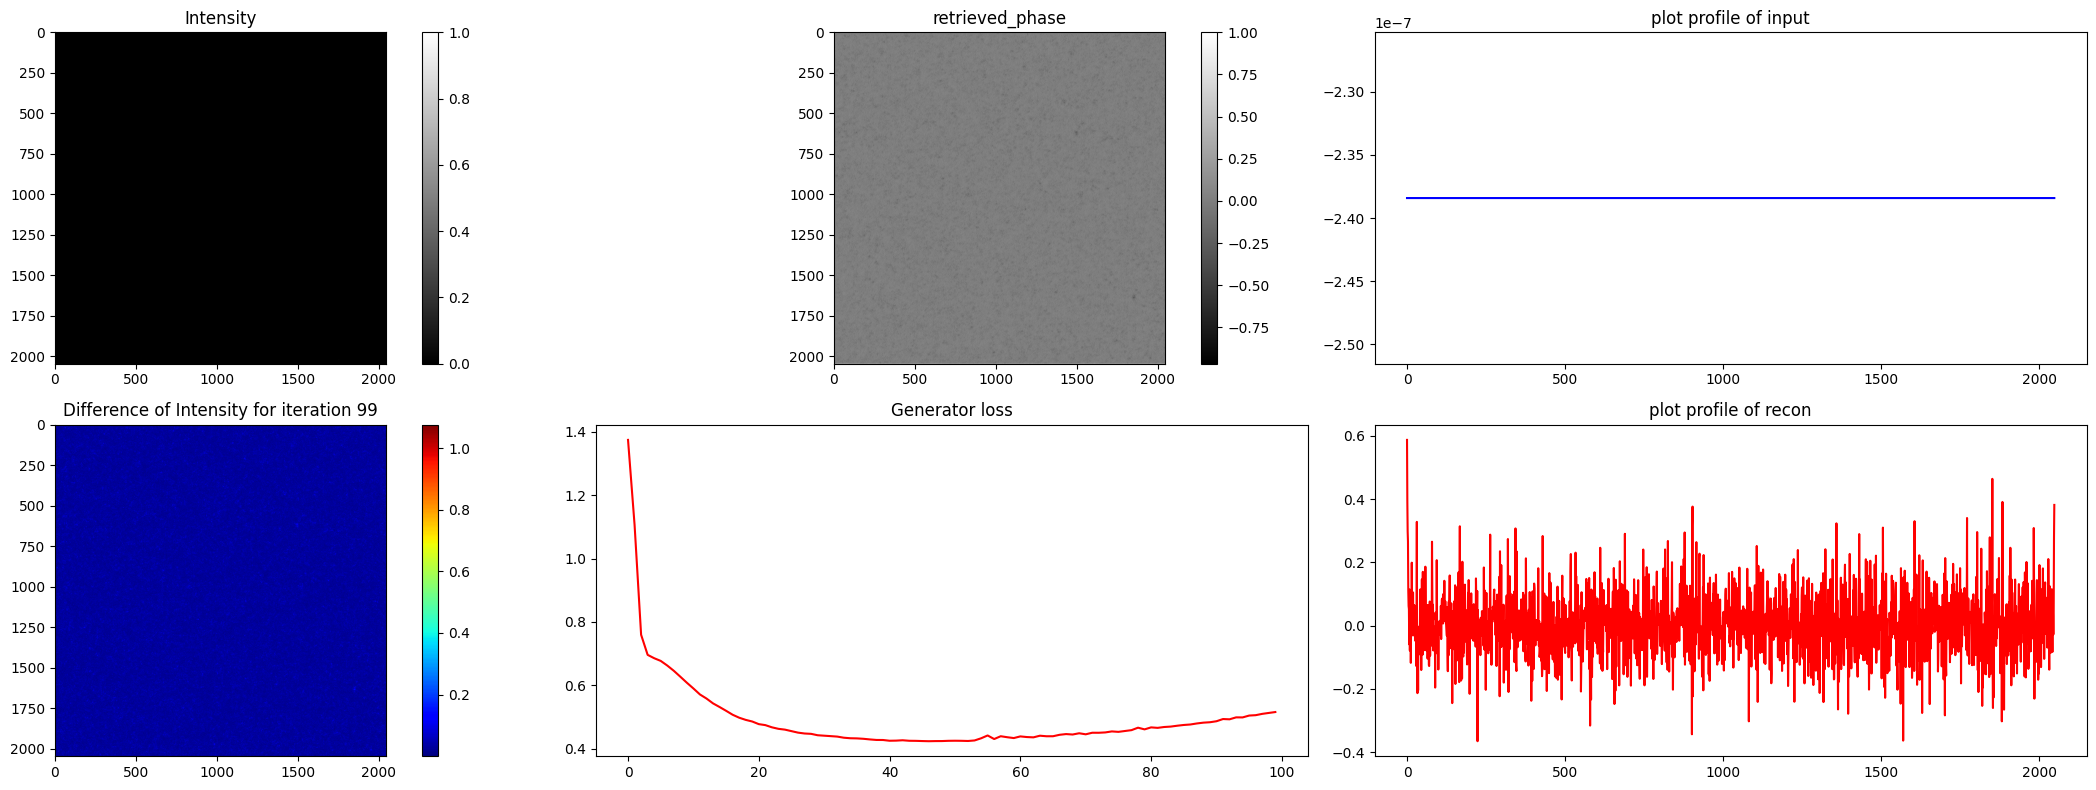

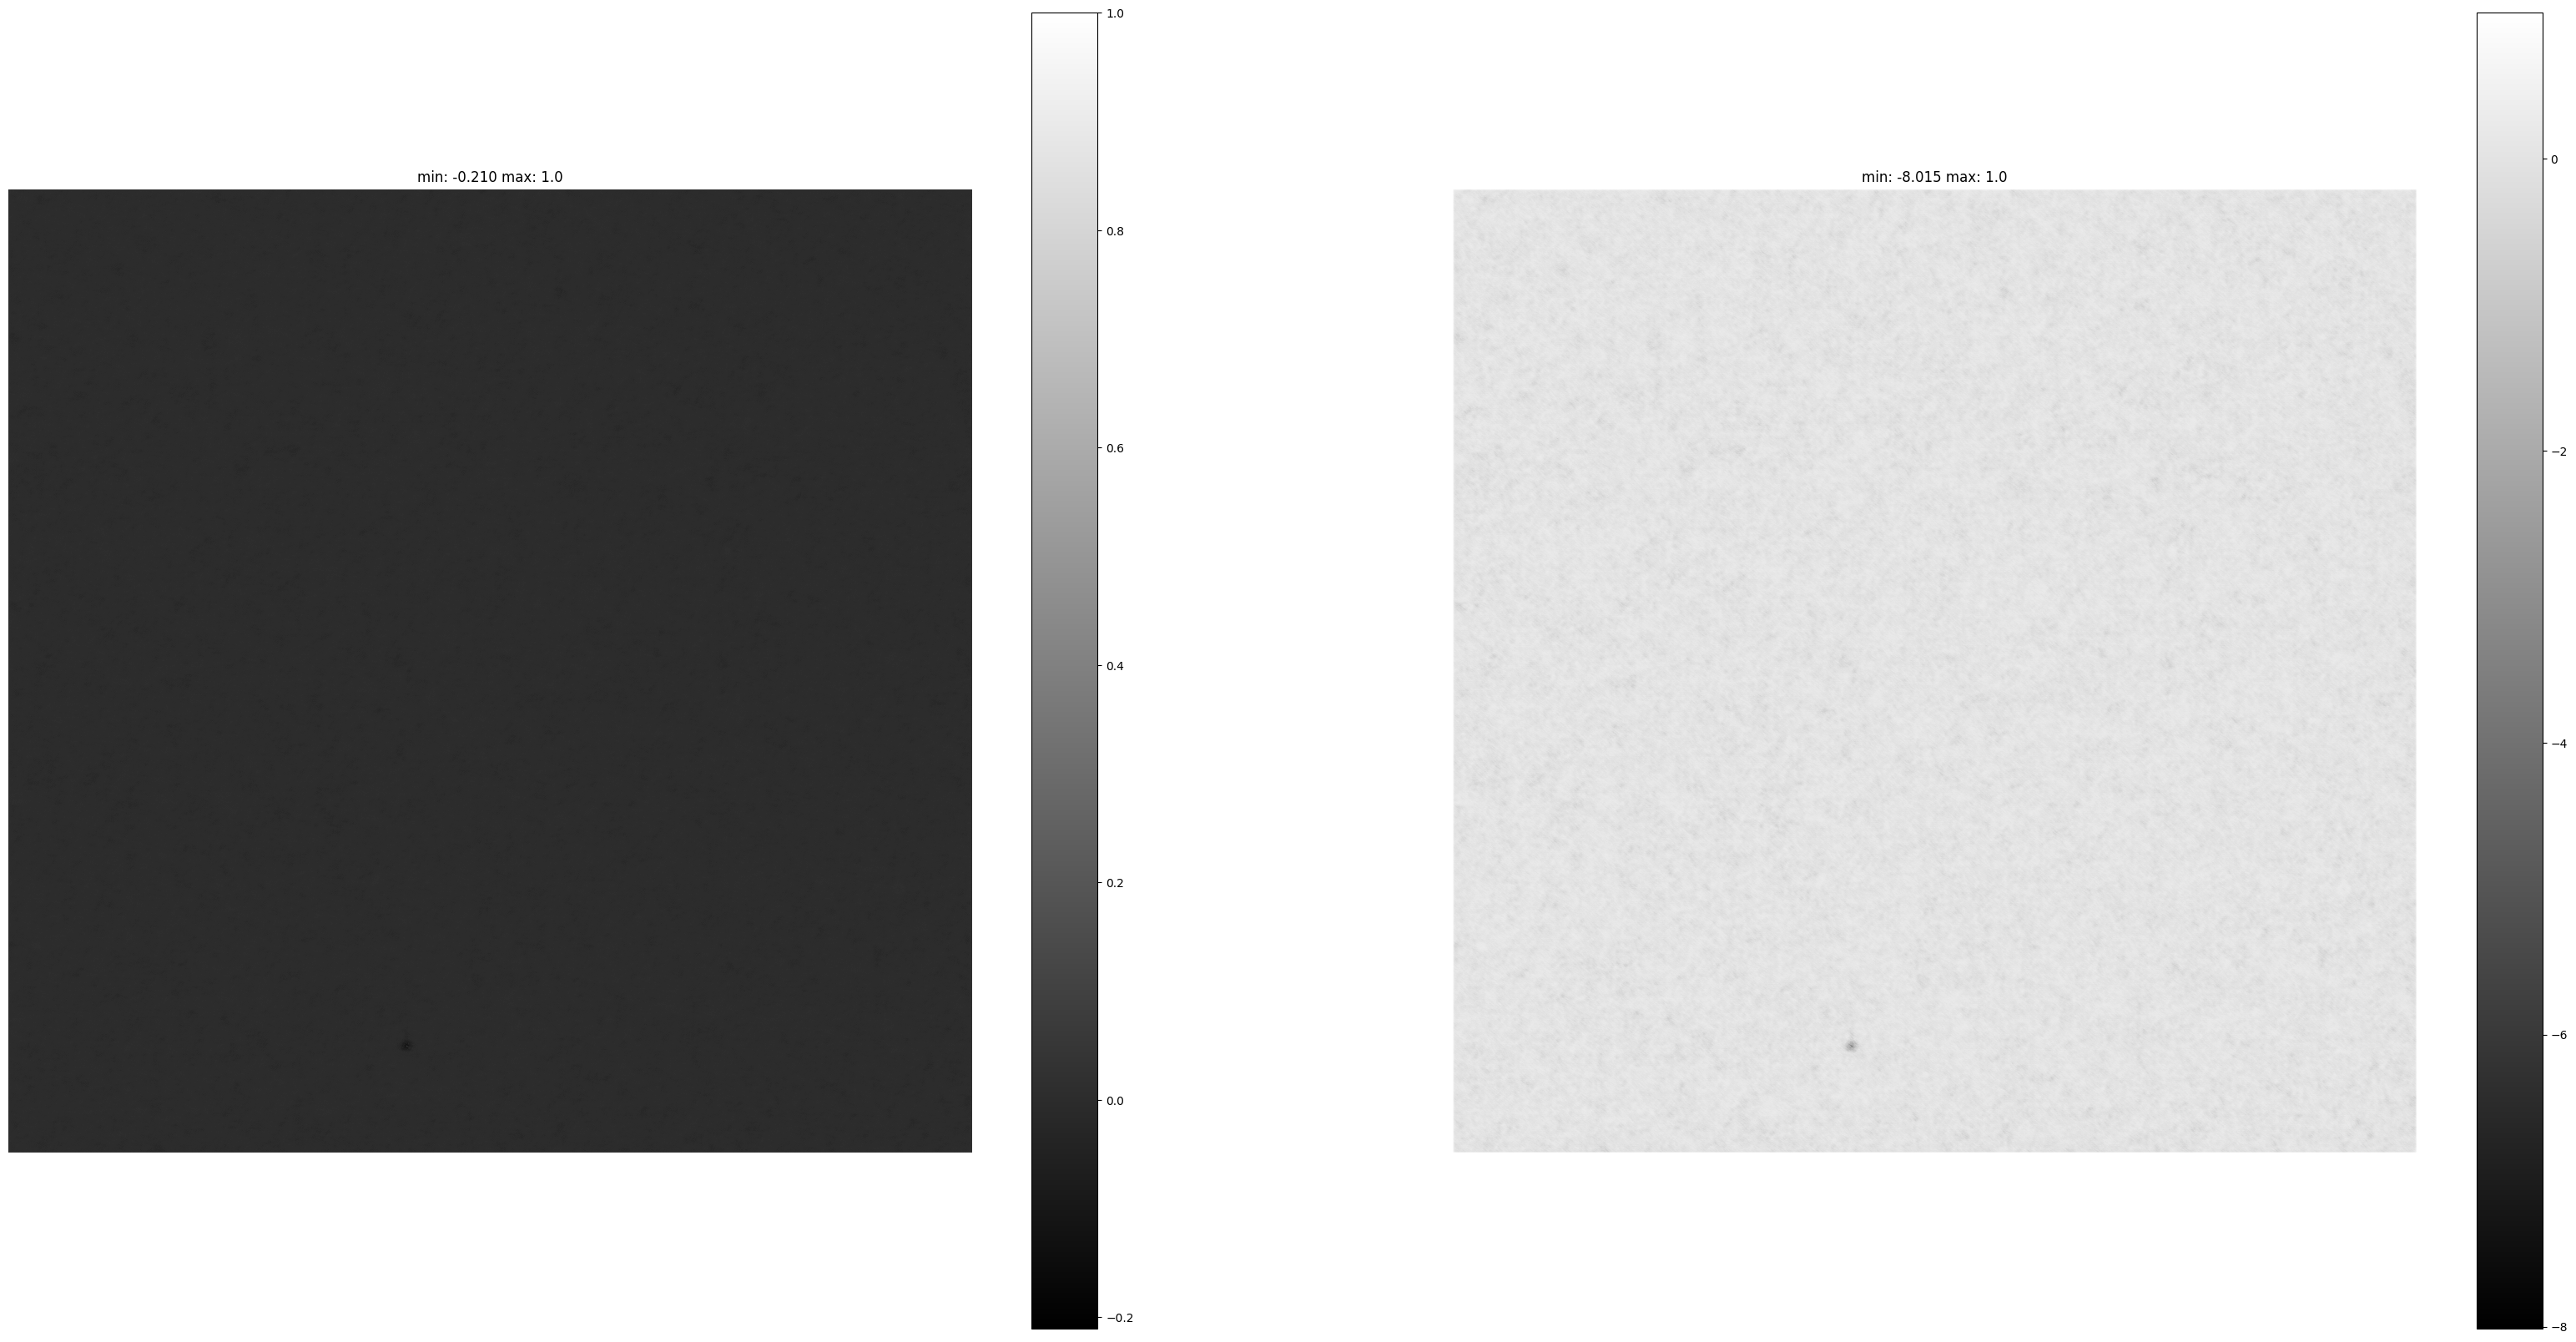

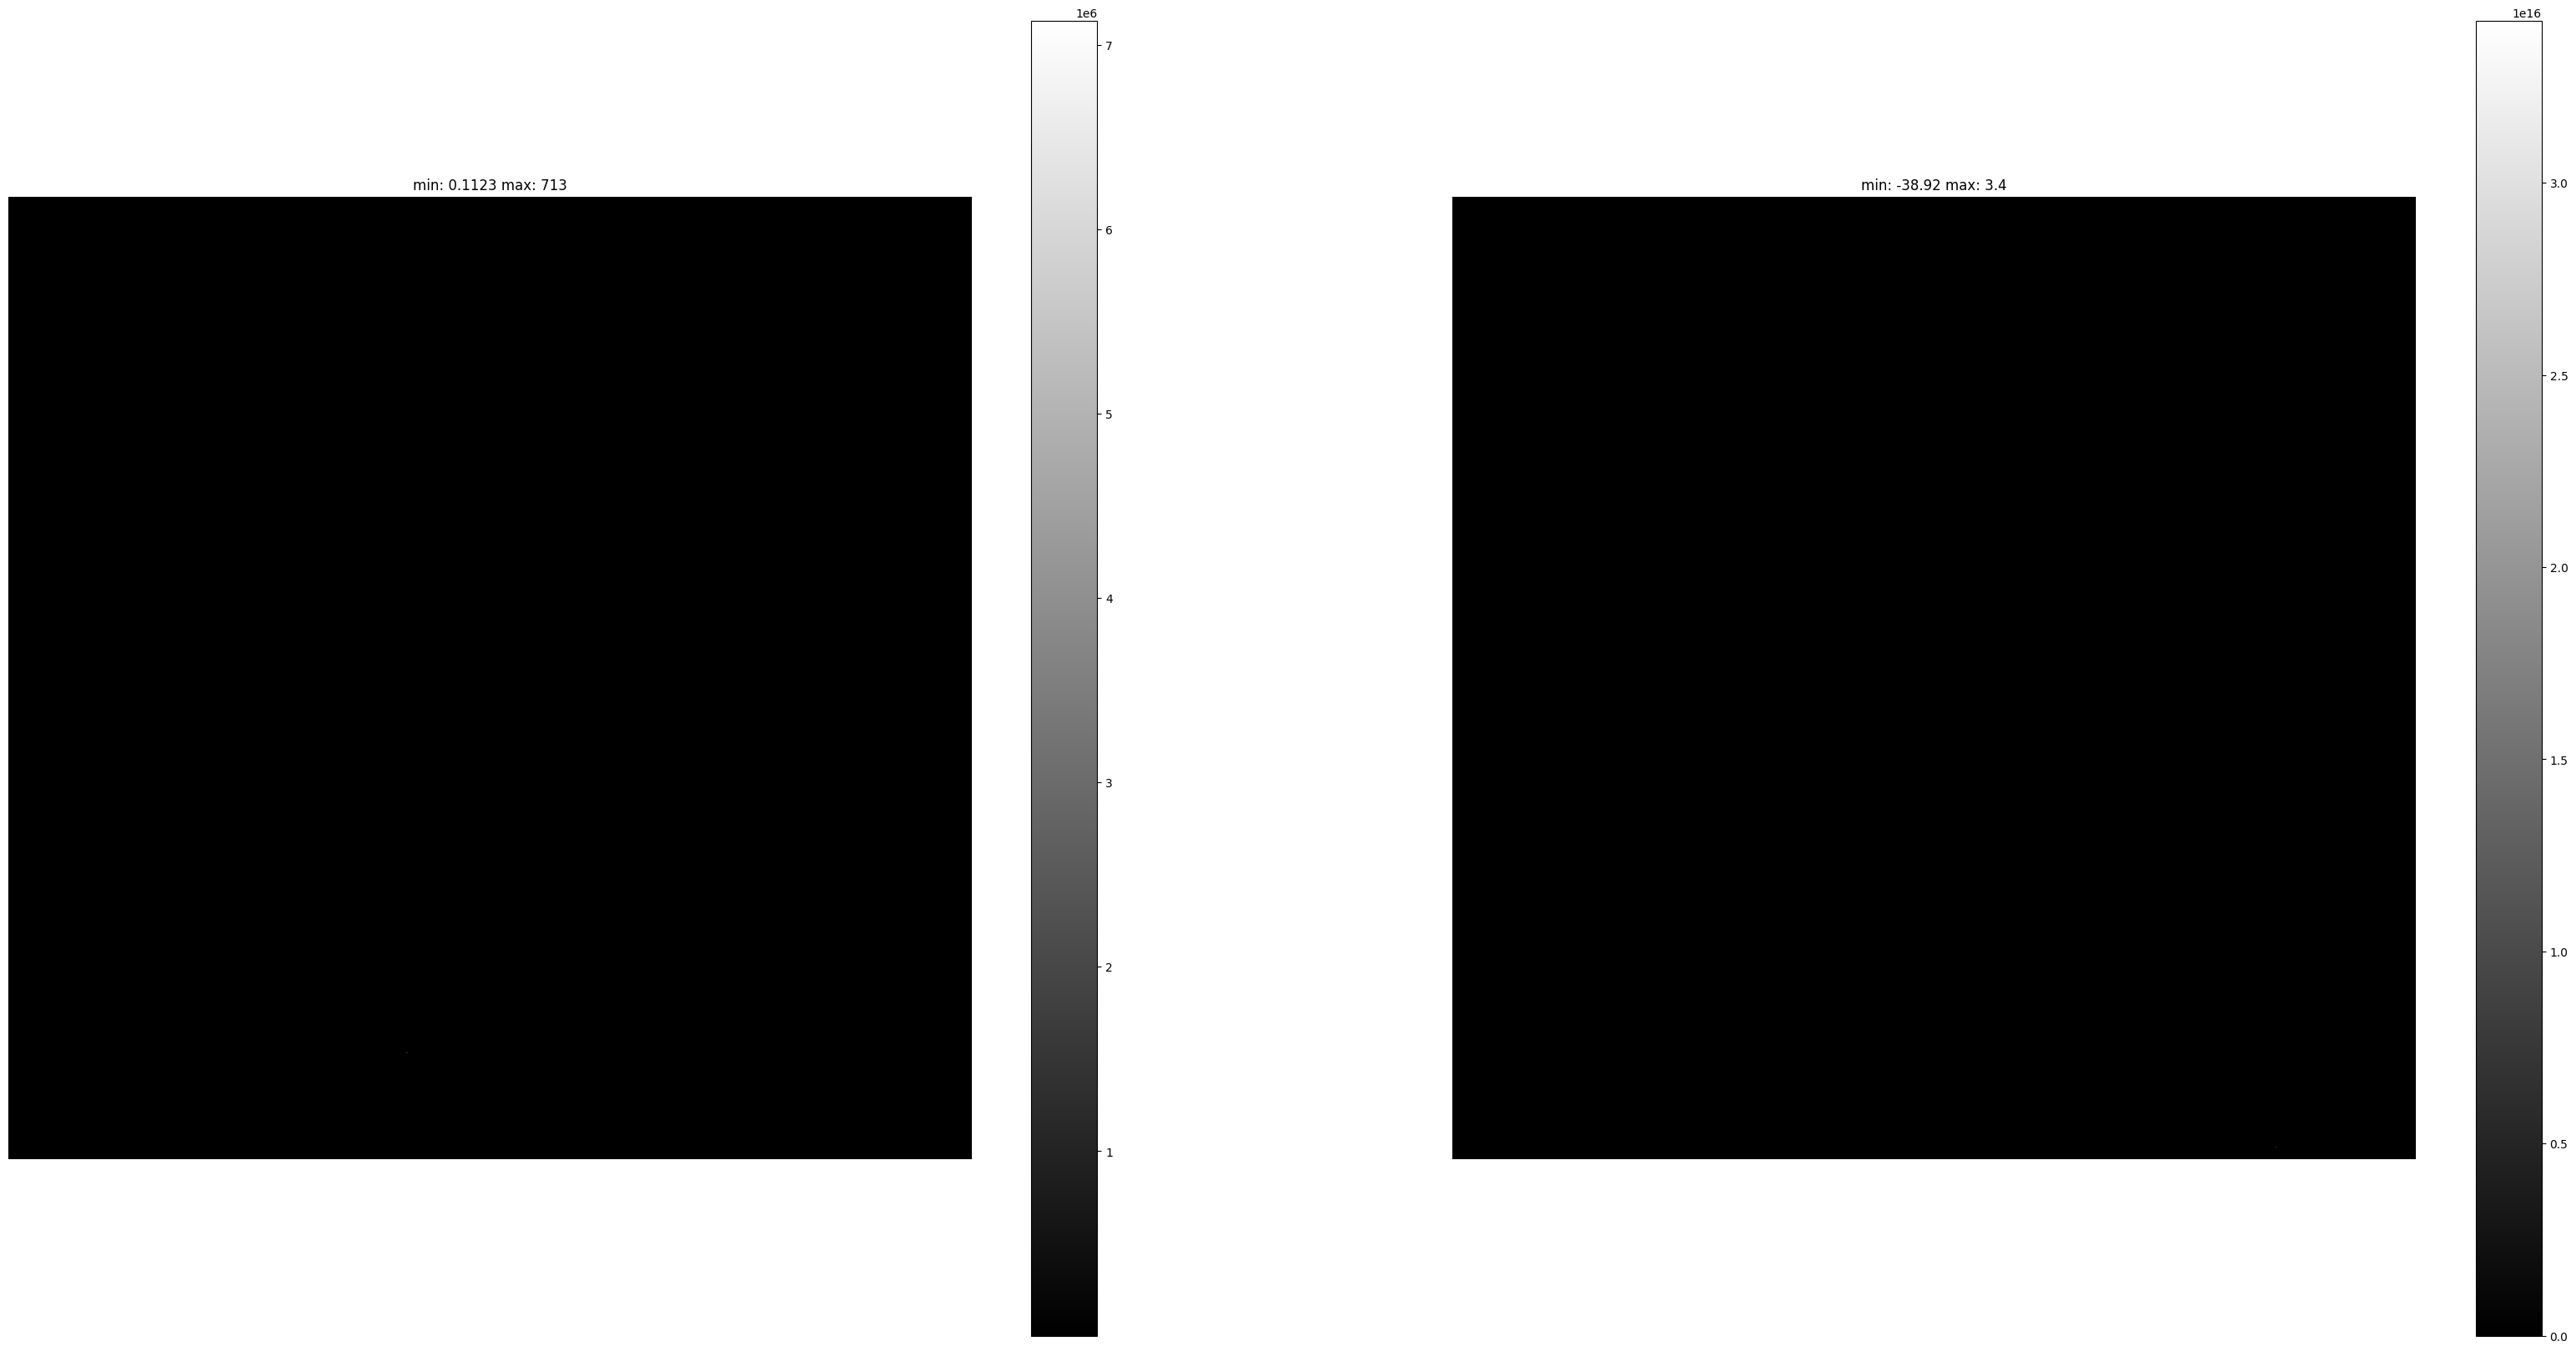

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-4.239146e-06], dtype=float32)>

In [ ]:

info = {
    'path': "/asap3/petra3/gpfs/p05/2018/data/11005102/processed/nano_2029_spider_hair/flat_field_corr/",
    'idx': 2,
    'energy_kev': 18.0,
    'detector_pixel_size': 2.57 * 1e-6,
    'distance_sample_detector': 0.15,
    'pad': 1,
    'alpha': 1e-8,
    'init_model': False,
    'transform_type': 'normalize',
}
args.update(info)
dataloader = Ganrec_Dataloader(**args)
ganphase = dataloader.create_ganphase_class()
retrieved = dataloader.train_model()

phase = retrieved[1]
attenuation = retrieved[0]
propagated = FresnelPropagator(phase, attenuation, dataloader.kwargs['fresnel_factor'], ref_image = None, dark_image = None)
print("phase shape: {}".format(phase.shape))
print("attenuation shape: {}".format(attenuation.shape))
visualize([phase, attenuation])
visualize([propagated[0, :, :, 0], dataloader.image])

matched = tfback_phase(dataloader.transformed_images[0,:,:,0], propagated[0,:,:,0])
tf.image.ssim(matched, propagated, max_val = 1.0)